In [ ]:
!pip3 install gymnasium[classic_control]
!pip install pyvirtualdisplay
!apt-get install -y xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from pyvirtualdisplay import Display
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Start the virtual display
display = Display(visible=0, size=(1400, 900))  # Size is adjustable
display.start()

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder="videos", disable_logger=True)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# Define two network structures for experimentation
class DQN3Layer(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN3Layer, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DQN5Layer(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN5Layer, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 128)
        self.layer5 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

In [ ]:
BATCH_SIZE = 64 # the number of transitions sampled from the replay buffer
GAMMA = 0.995 # the discount factor as mentioned in the previous section
EPS_START = 1 # the starting value of epsilon
EPS_END = 0.005 # the final value of epsilon
EPS_DECAY = 1000 # controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005 # the update rate of the target network
LR = 0.001 # the learning rate of the ``AdamW`` optimizer

# Log hyperparameters
print("Hyperparameters:")
print(f"BATCH_SIZE: {BATCH_SIZE}, GAMMA: {GAMMA}, EPS_START: {EPS_START}, EPS_END: {EPS_END}")
print(f"EPS_DECAY: {EPS_DECAY}, TAU: {TAU}, LR: {LR}")

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

# Choose a network structure (either DQN3Layer or DQN5Layer)
policy_net = DQN3Layer(n_observations, n_actions)
target_net = DQN3Layer(n_observations, n_actions)
# policy_net = DQN5Layer(n_observations, n_actions)
# target_net = DQN5Layer(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())

print("Using DQN3Layer network structure:")
print(policy_net)

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0
episode_rewards = []  # Track the reward for each episode
losses = []  # Track the loss for each training step

# epsilon - greedy
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Hyperparameters:
BATCH_SIZE: 64, GAMMA: 0.995, EPS_START: 1, EPS_END: 0.005
EPS_DECAY: 1000, TAU: 0.005, LR: 0.001
Using DQN3Layer network structure:
DQN3Layer(
  (layer1): Linear(in_features=4, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE) # episode
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute MSE loss
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    losses.append(loss.item())  # Store loss for plotting


    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
num_episodes = 500

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    episode_reward = 0  # Track reward per episode

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward])
        done = terminated or truncated

        episode_reward += reward.item()

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(episode_reward)  # Add episode reward for tracking

            plot_durations()
            break

    # Stop if average reward over last 100 episodes >= 475.0
    if len(episode_rewards) >= 100 and np.mean(episode_rewards[-100:]) >= 475.0:
        print(f"Agent achieved an average reward of 475.0 over 100 episodes at episode {i_episode}")
        break

print('Complete')


env.close()

Agent achieved an average reward of 475.0 over 100 episodes at episode 362
Complete


<Figure size 640x480 with 0 Axes>

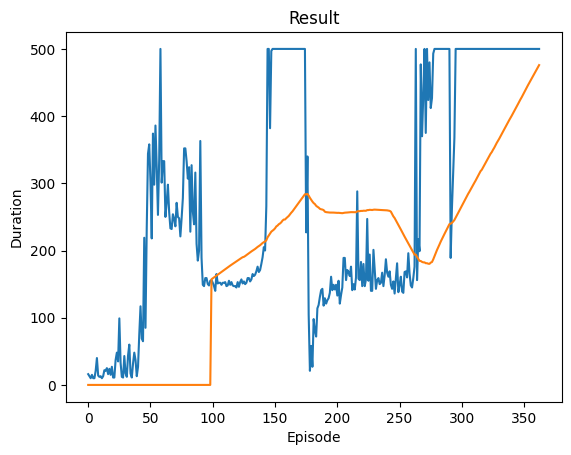

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

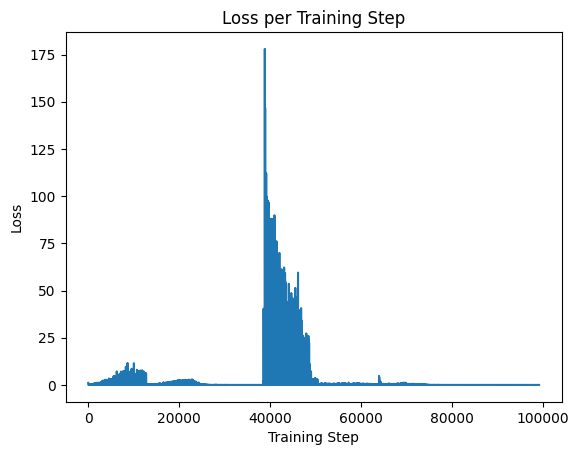

In [ ]:
# Plot loss values
plt.figure(3)
plt.title('Loss per Training Step')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()